In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from tools import compute_PCA, compute_TSNE, load_data

In [2]:
X, y, p = load_data([1, 2, 3, 4, 5, 6], z_score_norm="participant_meanfree")
X = X.reshape(X.shape[0], X.shape[1] * X.shape[1])

load: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06']
before: 0.010833320819703356 0.0138765904356241
after global: 3.7341964632401687e-16 1.2809175198047977
before: 0.014157458413294332 0.019697427174936128
after global: 7.13623604653435e-16 1.3913109683896072
before: 0.009671310470783361 0.01382165546457677
after global: 1.879732444483046e-16 1.4291398778202222
before: 0.014321327169414132 0.02092426207628347
after global: -1.1939835361469534e-16 1.4610560759320643
before: 0.008012871473850146 0.008465251726686069
after global: -3.320558536739763e-16 1.0564566964929187
before: 0.015501076883670332 0.020161922062374903
after global: -1.9424262392568686e-16 1.3006787988784543


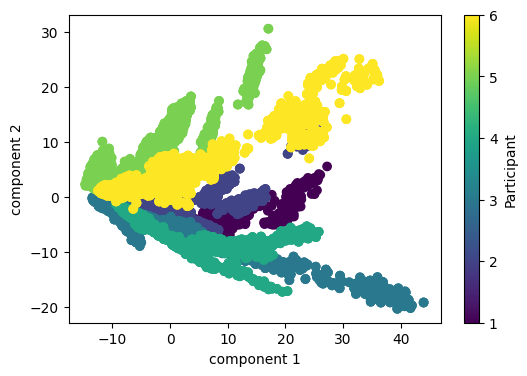

In [68]:
compute_PCA(
    X,
    feature=p,
    feature_label="Participant",
)

**3 level classification***

- low torque
- medium torque 
- high torque

In [8]:
def classification(y, levels=3, prints: bool = True):
    if levels == 3:
        lower_bound = np.percentile(y, 33.3)
        upper_bound = np.percentile(y, 66.6)

        categories = list()
        labels = list()

        for value in y:
            if value <= lower_bound:
                categories.append(0)
                labels.append("low")
            elif value <= upper_bound:
                categories.append(1 / 2)
                labels.append("medium")
            else:
                categories.append(1)
                labels.append("high")

        categories = np.array(categories)
        labels = np.array(labels)
        if prints:
            print(
                "low:",
                len(np.where(labels == "low")[0]),
                "medium:",
                len(np.where(labels == "medium")[0]),
                "high:",
                len(np.where(labels == "high")[0]),
            )
    elif levels == 2:
        bound = np.percentile(y, 50.0)

        categories = list()
        labels = list()

        for value in y:
            if value <= bound:
                categories.append(0)
                labels.append("low")
            else:
                categories.append(1)
                labels.append("high")

        categories = np.array(categories)
        labels = np.array(labels)
        if prints:
            print(
                "low:",
                len(np.where(labels == "low")[0]),
                "high:",
                len(np.where(labels == "high")[0]),
            )
    return categories, labels

In [9]:
y_cat, y_lab = classification(y, 2)

low: 1062 high: 1062


load: ['P02']
before: 0.014157458413294332 0.019697427174936128
after global: 7.13623604653435e-16 1.3913109683896072
low: 2000 high: 2000


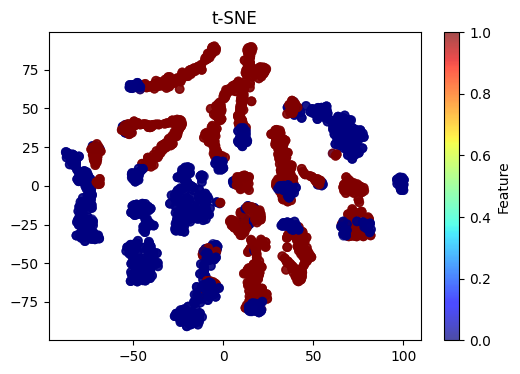

In [15]:
X, y, p = load_data([2], z_score_norm="participant_meanfree")
X = X.reshape(X.shape[0], X.shape[1] * X.shape[1])
y_cat, y_lab = classification(y, levels=2)
compute_TSNE(X, feature=y_cat)

In [79]:
selcts = np.where(y_lab == "low")[0]
print("low range:\t", np.min(y[selcts]), np.max(y[selcts]))
selcts = np.where(y_lab == "medium")[0]
print("medium range:\t", np.min(y[selcts]), np.max(y[selcts]))
selcts = np.where(y_lab == "high")[0]
print("high range:\t", np.min(y[selcts]), np.max(y[selcts]))

low range:	 -3.7464155244767405 28.71949418387857
medium range:	 28.719563060900185 50.054855450403494
high range:	 50.05581255344654 121.41029270813917


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_lab, test_size=0.2, random_state=42
)

**SVM Method**

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train SVM model
svm_model = SVC(kernel="rbf")
svm_model.fit(X_train, y_train)

SVC()

SVM Accuracy: 0.83


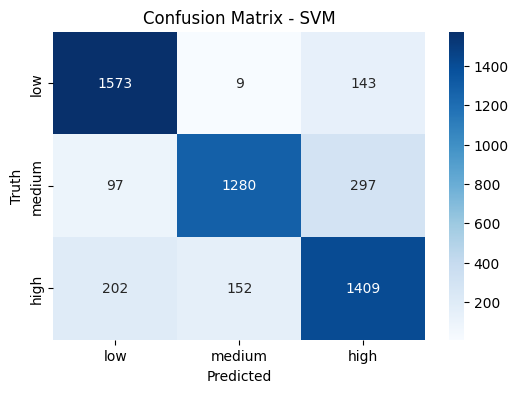

              precision    recall  f1-score   support

         low       0.84      0.91      0.87      1725
      medium       0.89      0.76      0.82      1674
        high       0.76      0.80      0.78      1763

    accuracy                           0.83      5162
   macro avg       0.83      0.83      0.83      5162
weighted avg       0.83      0.83      0.83      5162



In [16]:
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"],
)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("Confusion Matrix - SVM")
plt.show()

print(classification_report(y_test, y_pred_svm, target_names=["low", "medium", "high"]))

**Random forest**

Random Forest Accuracy: 0.98


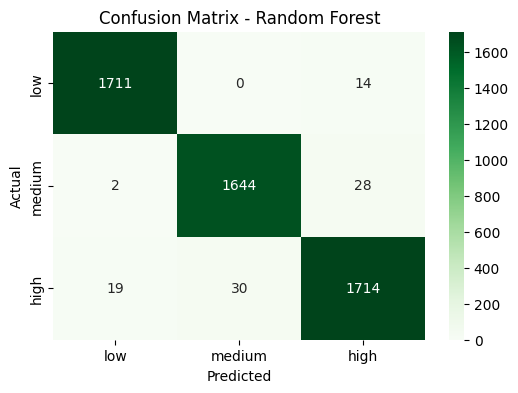

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      1725
      medium       0.98      0.98      0.98      1674
        high       0.98      0.97      0.97      1763

    accuracy                           0.98      5162
   macro avg       0.98      0.98      0.98      5162
weighted avg       0.98      0.98      0.98      5162



In [17]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

print(classification_report(y_test, y_pred_rf, target_names=["low", "medium", "high"]))

### Test with unknown participant

In [63]:
X, y, p = load_data([1, 3, 4, 5, 6], z_score_norm="participant_meanfree")
X_train = X.reshape(X.shape[0], X.shape[1] * X.shape[1])
_, y_train = classification(y)

X_test, y_test, p_test = load_data([2], z_score_norm="participant_meanfree")
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[1])

# test data of participant
_, y_test = classification(y_test)

load: ['P01', 'P03', 'P04', 'P05', 'P06']
before: 0.010833320819703356 0.0138765904356241
after global: 3.7341964632401687e-16 1.2809175198047977
before: 0.009671310470783361 0.01382165546457677
after global: 1.879732444483046e-16 1.4291398778202222
before: 0.014321327169414132 0.02092426207628347
after global: -1.1939835361469534e-16 1.4610560759320643
before: 0.008012871473850146 0.008465251726686069
after global: -3.320558536739763e-16 1.0564566964929187
before: 0.015501076883670332 0.020161922062374903
after global: -1.9424262392568686e-16 1.3006787988784543
low: 7263 medium: 7262 high: 7284
load: ['P02']
before: 0.014157458413294332 0.019697427174936128
after global: 7.13623604653435e-16 1.3913109683896072
low: 1332 medium: 1332 high: 1336


Random Forest Accuracy: 0.32


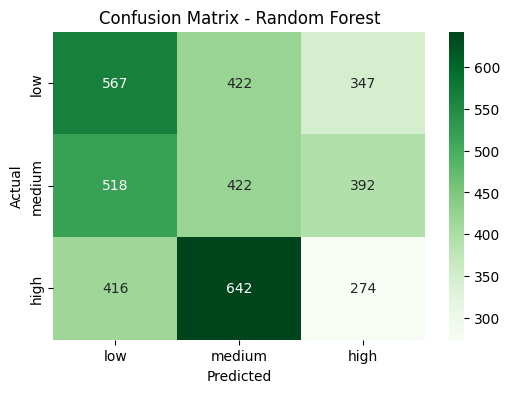

              precision    recall  f1-score   support

         low       0.38      0.42      0.40      1336
      medium       0.28      0.32      0.30      1332
        high       0.27      0.21      0.23      1332

    accuracy                           0.32      4000
   macro avg       0.31      0.32      0.31      4000
weighted avg       0.31      0.32      0.31      4000



In [64]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

print(classification_report(y_test, y_pred_rf, target_names=["low", "medium", "high"]))

### Test with unknown participant - crossvadidation

Train participant: [2 3 4 5 6]
Test participant: 1
low: 7887 medium: 7887 high: 7911
low: 707 medium: 707 high: 710
SVM Accuracy: 0.25


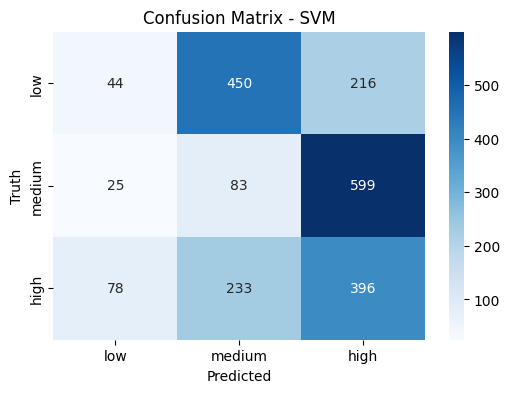

              precision    recall  f1-score   support

         low       0.30      0.06      0.10       710
      medium       0.11      0.12      0.11       707
        high       0.33      0.56      0.41       707

    accuracy                           0.25      2124
   macro avg       0.24      0.25      0.21      2124
weighted avg       0.24      0.25      0.21      2124

Train participant: [1 3 4 5 6]
Test participant: 2
low: 7263 medium: 7262 high: 7284
low: 1332 medium: 1332 high: 1336
SVM Accuracy: 0.28


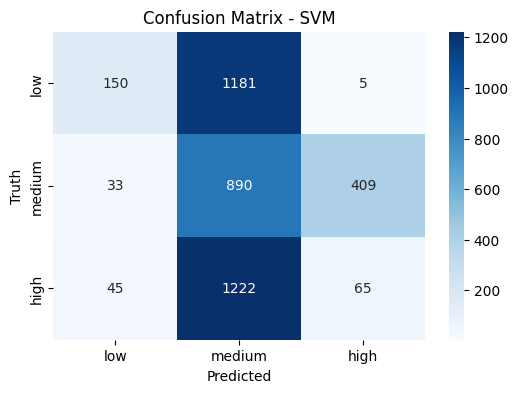

              precision    recall  f1-score   support

         low       0.66      0.11      0.19      1336
      medium       0.27      0.67      0.38      1332
        high       0.14      0.05      0.07      1332

    accuracy                           0.28      4000
   macro avg       0.35      0.28      0.22      4000
weighted avg       0.35      0.28      0.22      4000

Train participant: [1 2 4 5 6]
Test participant: 3
low: 7067 medium: 7066 high: 7088
low: 1528 medium: 1527 high: 1533
SVM Accuracy: 0.25


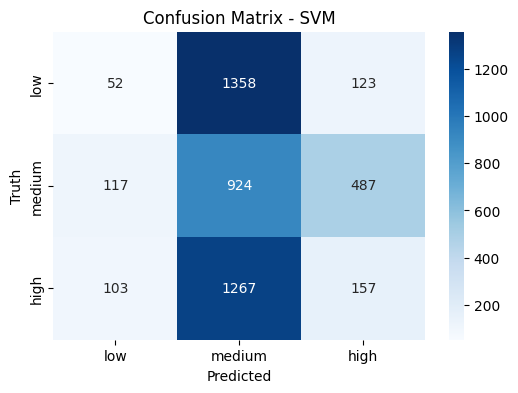

              precision    recall  f1-score   support

         low       0.19      0.03      0.06      1533
      medium       0.26      0.60      0.36      1528
        high       0.20      0.10      0.14      1527

    accuracy                           0.25      4588
   macro avg       0.22      0.25      0.19      4588
weighted avg       0.22      0.25      0.19      4588

Train participant: [1 2 3 5 6]
Test participant: 4
low: 7078 medium: 7078 high: 7100
low: 1516 medium: 1516 high: 1521
SVM Accuracy: 0.35


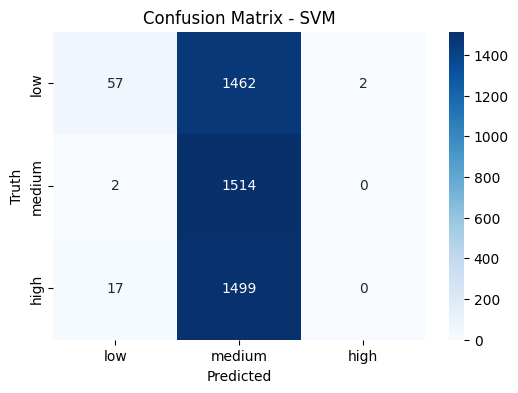

              precision    recall  f1-score   support

         low       0.75      0.04      0.07      1521
      medium       0.34      1.00      0.51      1516
        high       0.00      0.00      0.00      1516

    accuracy                           0.35      4553
   macro avg       0.36      0.35      0.19      4553
weighted avg       0.36      0.35      0.19      4553

Train participant: [1 2 3 4 6]
Test participant: 5
low: 6876 medium: 6875 high: 6897
low: 1719 medium: 1718 high: 1724
SVM Accuracy: 0.33


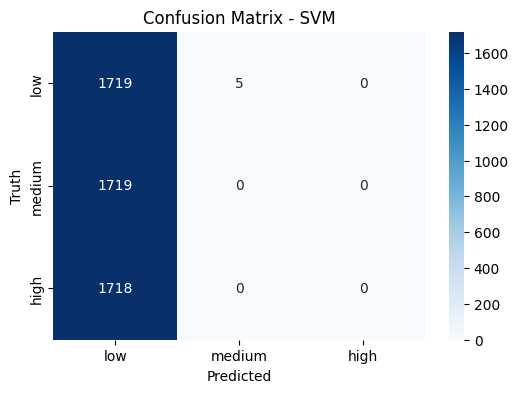

/home/jacob/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jacob/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jacob/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         low       0.33      1.00      0.50      1724
      medium       0.00      0.00      0.00      1719
        high       0.00      0.00      0.00      1718

    accuracy                           0.33      5161
   macro avg       0.11      0.33      0.17      5161
weighted avg       0.11      0.33      0.17      5161

Train participant: [1 2 3 4 5]
Test participant: 6
low: 6802 medium: 6802 high: 6822
low: 1793 medium: 1792 high: 1798
SVM Accuracy: 0.35


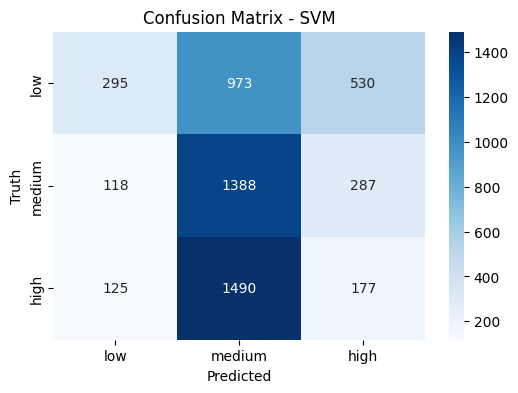

              precision    recall  f1-score   support

         low       0.55      0.16      0.25      1798
      medium       0.36      0.77      0.49      1793
        high       0.18      0.10      0.13      1792

    accuracy                           0.35      5383
   macro avg       0.36      0.35      0.29      5383
weighted avg       0.36      0.35      0.29      5383



In [65]:
load_part_list = np.array([1, 2, 3, 4, 5, 6])
for ps in range(1, len(load_part_list) + 1):
    new_arr = np.delete(load_part_list, ps - 1)
    print("Train participant:", new_arr)
    print("Test participant:", ps)

    X, y, p = load_data(new_arr, z_score_norm="participant_meanfree", print_info=False)
    X_train = X.reshape(X.shape[0], X.shape[1] * X.shape[1])
    _, y_train = classification(y)

    X_test, y_test, p_test = load_data(
        [ps], z_score_norm="participant_meanfree", print_info=False
    )
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[1])

    # test data of participant
    _, y_test = classification(y_test)

    # model
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train SVM model
    svm_model = SVC(kernel="rbf")
    svm_model.fit(X_train, y_train)

    y_pred_svm = svm_model.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    print(f"SVM Accuracy: {accuracy_svm:.2f}")
    cm_svm = confusion_matrix(y_test, y_pred_svm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm_svm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["low", "medium", "high"],
        yticklabels=["low", "medium", "high"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.title("Confusion Matrix - SVM")
    plt.show()

    print(
        classification_report(
            y_test, y_pred_svm, target_names=["low", "medium", "high"]
        )
    )

Train participant: [2 3 4 5 6]
Test participant: 1
low: 7887 medium: 7887 high: 7911
low: 707 medium: 707 high: 710
Random Forest Accuracy: 0.38


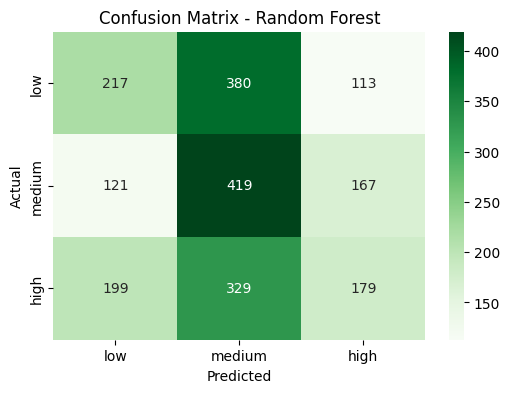

              precision    recall  f1-score   support

         low       0.40      0.31      0.35       710
      medium       0.37      0.59      0.46       707
        high       0.39      0.25      0.31       707

    accuracy                           0.38      2124
   macro avg       0.39      0.38      0.37      2124
weighted avg       0.39      0.38      0.37      2124

Train participant: [1 3 4 5 6]
Test participant: 2
low: 7263 medium: 7262 high: 7284
low: 1332 medium: 1332 high: 1336
Random Forest Accuracy: 0.32


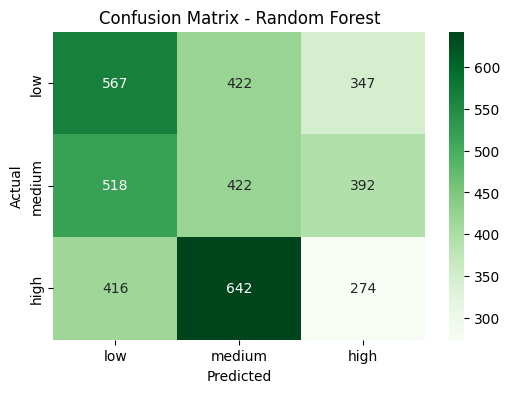

              precision    recall  f1-score   support

         low       0.38      0.42      0.40      1336
      medium       0.28      0.32      0.30      1332
        high       0.27      0.21      0.23      1332

    accuracy                           0.32      4000
   macro avg       0.31      0.32      0.31      4000
weighted avg       0.31      0.32      0.31      4000

Train participant: [1 2 4 5 6]
Test participant: 3
low: 7067 medium: 7066 high: 7088
low: 1528 medium: 1527 high: 1533
Random Forest Accuracy: 0.34


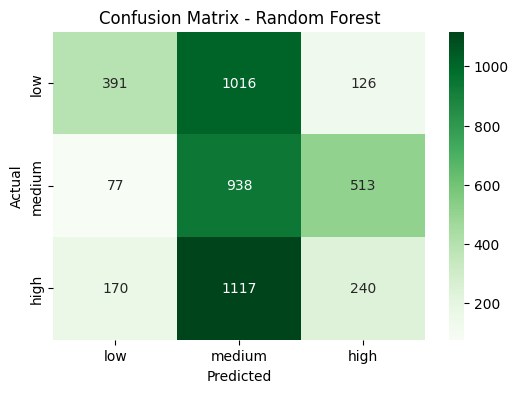

              precision    recall  f1-score   support

         low       0.61      0.26      0.36      1533
      medium       0.31      0.61      0.41      1528
        high       0.27      0.16      0.20      1527

    accuracy                           0.34      4588
   macro avg       0.40      0.34      0.32      4588
weighted avg       0.40      0.34      0.32      4588

Train participant: [1 2 3 5 6]
Test participant: 4
low: 7078 medium: 7078 high: 7100
low: 1516 medium: 1516 high: 1521
Random Forest Accuracy: 0.38


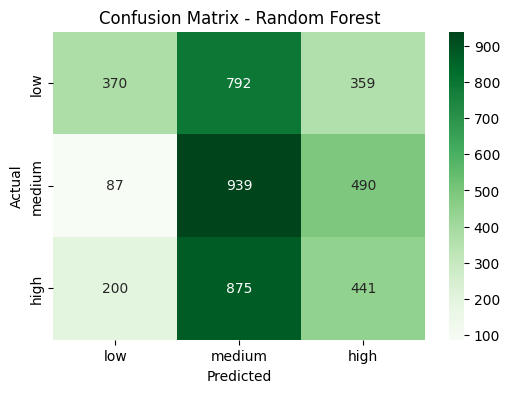

              precision    recall  f1-score   support

         low       0.56      0.24      0.34      1521
      medium       0.36      0.62      0.46      1516
        high       0.34      0.29      0.31      1516

    accuracy                           0.38      4553
   macro avg       0.42      0.38      0.37      4553
weighted avg       0.42      0.38      0.37      4553

Train participant: [1 2 3 4 6]
Test participant: 5
low: 6876 medium: 6875 high: 6897
low: 1719 medium: 1718 high: 1724
Random Forest Accuracy: 0.31


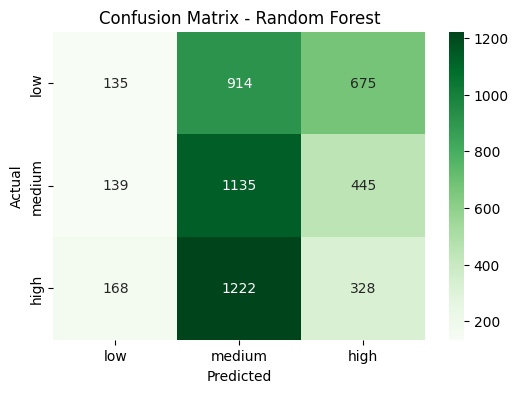

              precision    recall  f1-score   support

         low       0.31      0.08      0.12      1724
      medium       0.35      0.66      0.45      1719
        high       0.23      0.19      0.21      1718

    accuracy                           0.31      5161
   macro avg       0.29      0.31      0.26      5161
weighted avg       0.29      0.31      0.26      5161

Train participant: [1 2 3 4 5]
Test participant: 6
low: 6802 medium: 6802 high: 6822
low: 1793 medium: 1792 high: 1798
Random Forest Accuracy: 0.31


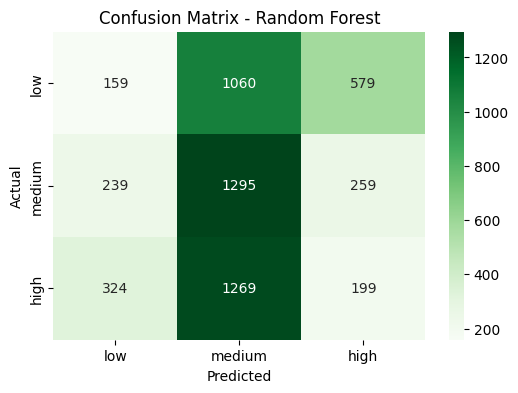

              precision    recall  f1-score   support

         low       0.22      0.09      0.13      1798
      medium       0.36      0.72      0.48      1793
        high       0.19      0.11      0.14      1792

    accuracy                           0.31      5383
   macro avg       0.26      0.31      0.25      5383
weighted avg       0.26      0.31      0.25      5383



In [62]:
load_part_list = np.array([1, 2, 3, 4, 5, 6])
for ps in range(1, len(load_part_list) + 1):
    new_arr = np.delete(load_part_list, ps - 1)
    print("Train participant:", new_arr)
    print("Test participant:", ps)

    X, y, p = load_data(new_arr, z_score_norm="participant_meanfree", print_info=False)
    X_train = X.reshape(X.shape[0], X.shape[1] * X.shape[1])
    _, y_train = classification(y)

    X_test, y_test, p_test = load_data(
        [ps], z_score_norm="participant_meanfree", print_info=False
    )
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[1])

    # test data of participant
    _, y_test = classification(y_test)

    # model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

    cm_rf = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm_rf,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=["low", "medium", "high"],
        yticklabels=["low", "medium", "high"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Random Forest")
    plt.show()

    print(
        classification_report(y_test, y_pred_rf, target_names=["low", "medium", "high"])
    )